In [1]:
#Imports
import sys
sys.path.append('../../python/')
import NGC5533_functions as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp

from datetime import datetime
import time as t

In [2]:
starttime = t.time()

data = dp.getXYdata_wXYerr('../data/100kpc_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#change r_dat so it's strictly increasing
r_dat, v_dat, v_err0, v_err1 = (list(a) for a in zip(*sorted(zip(r_dat, v_dat, v_err0, v_err1))))
#converting v_err1 to an array
v_err1 = np.asarray(v_err1)
#Express as weights
weighdata = 1/v_err1

In [3]:
#keeping others but holding them constant, All Parameters
def f(r,h,pref):
     return np.sqrt(nf.bh_v(r,load=True,path='../')**2 
                    + nf.h_v(r,load=True,path='../')**2 
                    + nf.b_v(r,load=True,path='../')**2 
                    + nf.d_v(r,h,pref,load=True,path='../')**2)
    
#keeping others but holding them constant, No h
def g(r,pref):
     return np.sqrt(nf.bh_v(r,load=True,path='../')**2 
                    + nf.h_v(r,load=True,path='../')**2 
                    + nf.b_v(r,load=True,path='../')**2 
                    + nf.d_v(r,pref,load=True,path='../')**2)

#Only Disk, All Parameters
def d(r,h,pref):
    return nf.d_v(r,h,pref,load=True,path='../')

#Only Disk, No h
def d2(r,pref):
    return nf.d_v(r,pref,load=True,path='../')

In [4]:
#Fit, Keeping rest constant, All Parameters

#Setup
l_mod = lm.Model(f)
l_params = l_mod.make_params()
#Disk Params
l_params.add('h', value=nf.h_c, min=0, max=1000)
l_params.add('pref', value=nf.pref_def, min=0)
#Do fit
l_fit = l_mod.fit(v_dat,l_params,r=r_dat,weights=weighdata)

In [5]:
#Fit, Keeping rest constant, No h

#Setup
g_mod = lm.Model(g)
g_params = g_mod.make_params()
#Disk Params
g_params.add('pref', value=nf.pref_def, min=0)
#Do fit
g_fit = g_mod.fit(v_dat,g_params,r=r_dat,weights=weighdata)

In [6]:
#Fit, D Only, All Parameters

#Setup
d_mod = lm.Model(d)
d_params = d_mod.make_params()
#Disk Params
d_params.add('h', value=nf.h_c, min=0, max=1000)
d_params.add('pref', value=nf.pref_def, min=0)
#Do fit
d_fit = d_mod.fit(v_dat,d_params,r=r_dat,weights=weighdata)

../../python/NGC5533_functions.py:320: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return u*si.quad(d_innerfunc, 0, np.inf, args=(r,u,h,d_rho00))[0]
../../python/NGC5533_functions.py:324: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return si.quad(d_innerintegral, 0, np.inf, args=(r,h,d_rho00))[0]
../../python/NGC5533_functions.py:324: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a s

In [7]:
#Fit, D Only, No h

#Setup
d2_mod = lm.Model(d2)
d2_params = d2_mod.make_params()
#Disk Params
d2_params.add('pref', value=nf.pref_def, min=0)
#Do fit
d2_fit = d2_mod.fit(v_dat,d2_params,r=r_dat,weights=weighdata)

In [8]:
#Define curves to plot

l_dict = l_fit.best_values
l_h = l_dict['h']
l_pref = l_dict['pref']
l_curve = f(r_dat,l_h,l_pref)

g_dict = g_fit.best_values
g_pref = g_dict['pref']
g_curve = g(r_dat,g_pref)

d_dict = d_fit.best_values
d_h = d_dict['h']
d_pref = d_dict['pref']

d2_dict = d2_fit.best_values
d2_pref = d2_dict['pref']

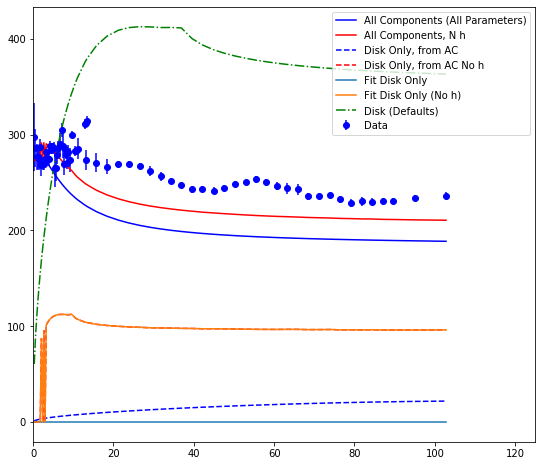

In [9]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,125)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,'b-',label='All Components (All Parameters)')
plt.plot(r_dat,g_curve,'r-',label='All Components, N h')
plt.plot(r_dat,d(r_dat,l_h,l_pref),'b--',label='Disk Only, from AC')
plt.plot(r_dat,d2(r_dat,g_pref),'r--',label='Disk Only, from AC No h')
plt.plot(r_dat,d(r_dat,d_h,d_pref),label='Fit Disk Only')
plt.plot(r_dat,d2(r_dat,d2_pref),label='Fit Disk Only (No h)')
plt.plot(r_dat,nf.d_v(r_dat,load=True,path='../'),'g-.',label='Disk (Defaults)')

plt.legend()
plt.show()

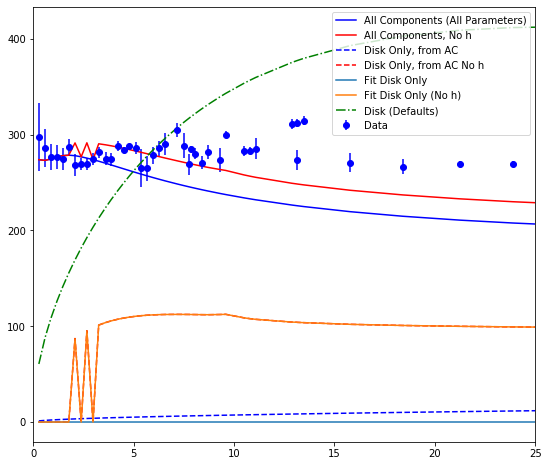

In [10]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,25)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,'b-',label='All Components (All Parameters)')
plt.plot(r_dat,g_curve,'r-',label='All Components, No h')
plt.plot(r_dat,d(r_dat,l_h,l_pref),'b--',label='Disk Only, from AC')
plt.plot(r_dat,d2(r_dat,g_pref),'r--',label='Disk Only, from AC No h')
plt.plot(r_dat,d(r_dat,d_h,d_pref),label='Fit Disk Only')
plt.plot(r_dat,d2(r_dat,d2_pref),label='Fit Disk Only (No h)')
plt.plot(r_dat,nf.d_v(r_dat,load=True,path='../'),'g-.',label='Disk (Defaults)')

plt.legend()
plt.show()

In [11]:
print('Fit information for all-component fit (All Parameters):')
l_fit

Fit information for all-component fit (All Parameters):


In [12]:
print('Fit information for all-component fit (No h):')
g_fit

Fit information for all-component fit (No h):


In [13]:
print('Fit information for single-component fit (All Parameters):')
d_fit

Fit information for single-component fit (All Parameters):


In [14]:
print('Fit information for single-component fit (No h):')
d2_fit

Fit information for single-component fit (No h):


In [15]:
endtime = t.time()
print('Total Time:')
print(str(endtime - starttime)+' seconds')
print('')

print('Timestamp:')
print(datetime.now())

Total Time:
10498.421511411667 seconds

Timestamp:
2019-10-15 14:08:27.129989
